In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.12/07


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Endcap_2GeV_add.4.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

def load_pgun_omtf():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Overlap_3GeV_add.4.root'
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

In [4]:
maxEvents = 500000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (0.8, 1.2, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4)
eta_bins = eta_bins[::-1]
pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)
nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT)

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def find_eta_bin(eta):
  ieta = np.digitize((np.abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def analysis(verbose=1, omtf=False):
  if omtf:
    tree = load_pgun_omtf()
  else:
    tree = load_pgun()
  
  out_phis = {}
  out_thetas = {}

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if omtf:
      pass
    else:
      if not len(evt.hits) >= 3:
        continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kDT and (hit.station == 1 or hit.station == 2):
        has_ME1 = True
        break
    #if not has_ME1:
    #  continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Skip events with muon pT < 5 GeV
    if part.pt < 5:
      continue
    
    # Find the best sector
    sector_cnt_array = np.zeros((12,), dtype=np.int32)
    sector_phi_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_phi_array.shape):
      sector_phi_array[ind] = []
    
    for ihit, hit in enumerate(evt.hits):
      #print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11}".format(ihit, hit.bx, hit.type, hit.station, hit.ring, hit.sector, hit.fr, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2))
      
      if (not hit.emtf_phi < 5040):
        print hit.type, hit.station, hit.ring, hit.emtf_phi
      #assert(hit.emtf_phi < 5040)  # 84*60
      endsec = find_endsec(hit.endcap, hit.sector)
      sector_cnt_array[endsec] += 1
      sector_phi_array[endsec].append(hit.emtf_phi)
    
    best_sector = np.argmax(sector_cnt_array)
    
    part_phi = np.rad2deg(part.phi)
    if best_sector == 2 or best_sector == 8:
      if part_phi < 0.:
        part_phi += 360.
    out_phis.setdefault(best_sector, []).append(part_phi)
    
    part_zone = find_eta_bin(part.eta)
    for ihit, hit in enumerate(evt.hits):
      endsec = find_endsec(hit.endcap, hit.sector)
      if endsec == best_sector:
        if (hit.sim_tp1 == 0 and hit.sim_tp2 == 0):
          hit_ring = int(hit.ring == 2 or hit.ring == 3)
          out_thetas.setdefault((part_zone, hit.type, hit.station, hit_ring), []).append(hit.emtf_theta)
    
  return (out_phis, out_thetas)

In [5]:
# Run analysis

(out_phis, out_thetas) = analysis()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Endcap_2GeV_add.4.root
Processing event: 0
Processing event: 10000
Processing event: 20000
0 1 1 5073
Processing event: 30000
0 1 1 5046
Processing event: 40000
Processing event: 50000
Processing event: 60000
Processing event: 70000
Processing event: 80000
Processing event: 90000
Processing event: 100000
Processing event: 110000
Processing event: 120000
Processing event: 130000
Processing event: 140000
Processing event: 150000
0 1 1 5043
Processing event: 160000
Processing event: 170000
0 1 1 5082
Processing event: 180000
Processing event: 190000
Processing event: 200000
Processing event: 210000
0 1 1 5051
Processing event: 220000
Processing event: 230000
Processing event: 240000
Processing event: 250000
Processing event: 260000
Processing event: 270000
0 1 1 5059
Processing event: 280000
Processing event: 290000
Processing event: 300000
Processing event: 310000
Processing event: 320000
Processing event: 330000
Processing event: 340000
Pr

In [6]:
# Styling
plt.style.use('tdrstyle.mplstyle')

DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Liberation Sans (u'/usr/share/fonts/liberation/LiberationSans-Regular.ttf') with score of 4.050000


0 [4.100860888683037, 38.91483266751907, 73.7288044463551]


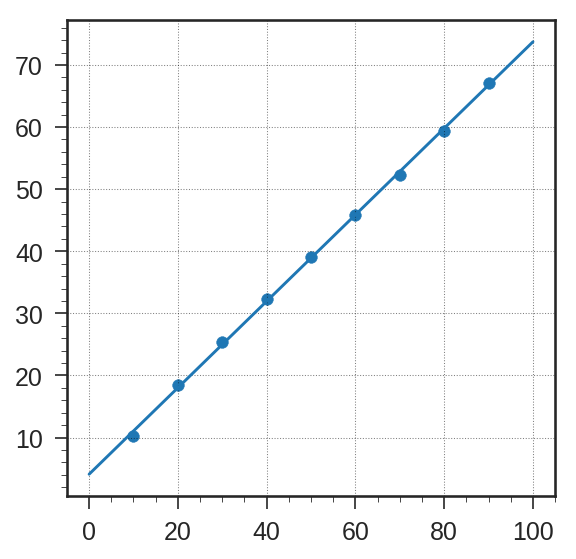

1 [70.30502506711886, 102.35910170362382, 134.4131783401288]


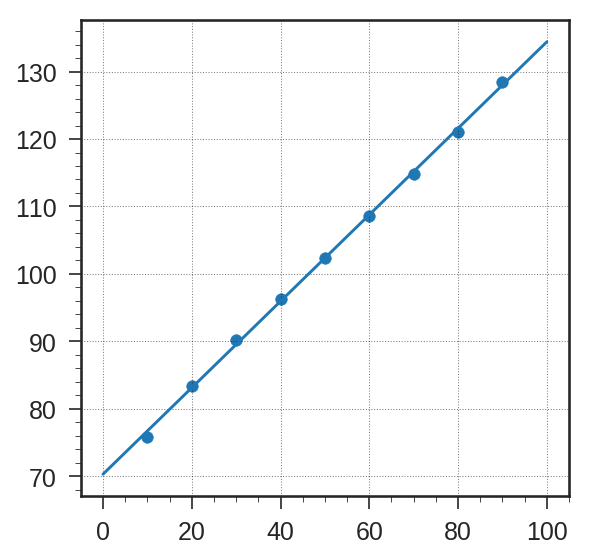

2 [130.64546587944068, 162.41577760145992, 194.1860893234792]


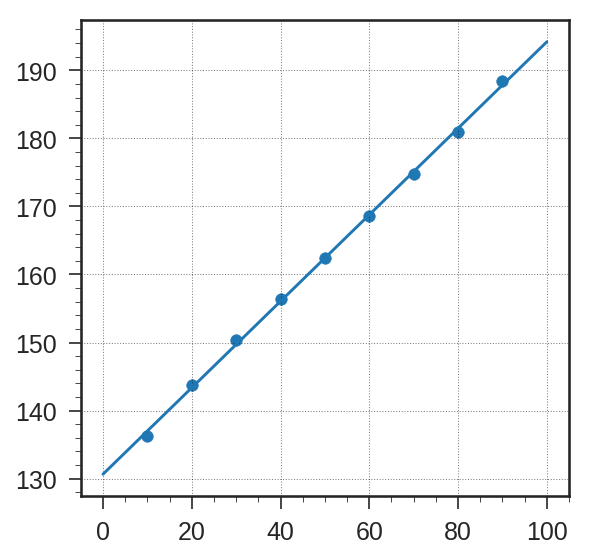

3 [190.9047124127321, 222.9119198358065, 254.9191272588809]


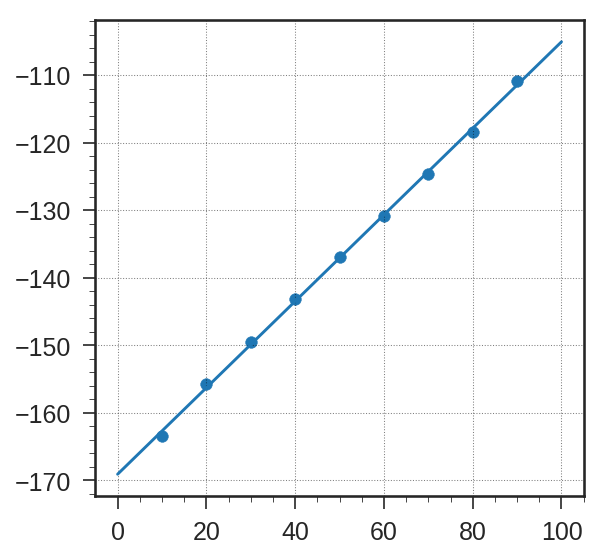

4 [250.5702049986004, 282.36547654669823, 314.160748094796]


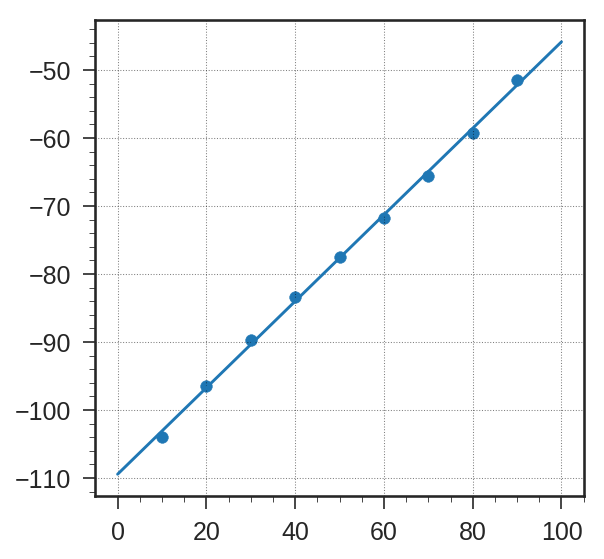

5 [309.9585116198325, 338.9971682452925, 8.035824870752563]


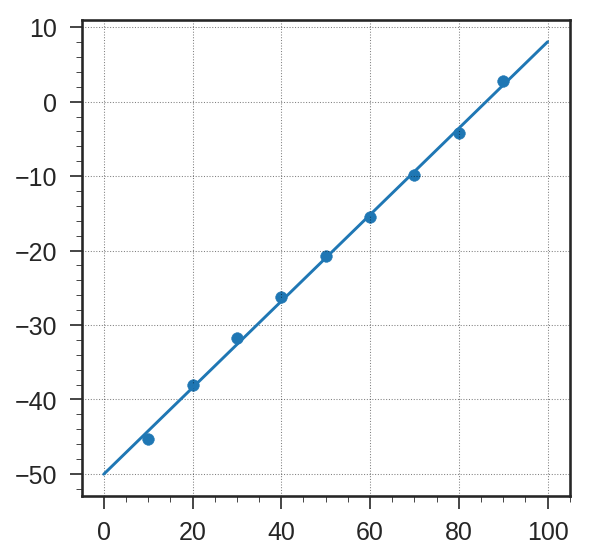

6 [3.951578509717713, 38.991688659676605, 74.03179880963549]


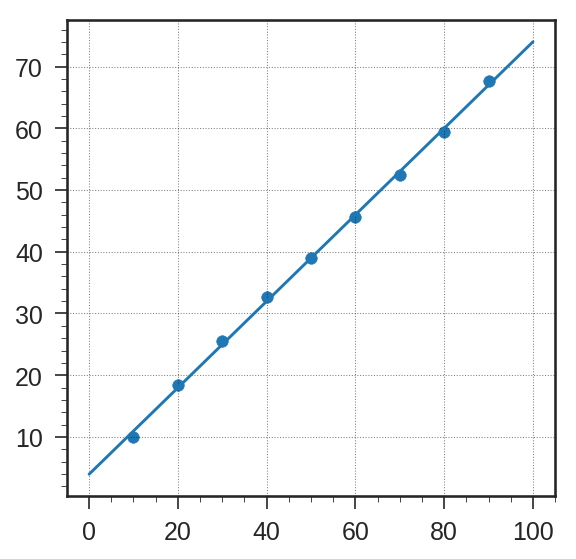

7 [70.75799934243354, 102.56355749693085, 134.36911565142816]


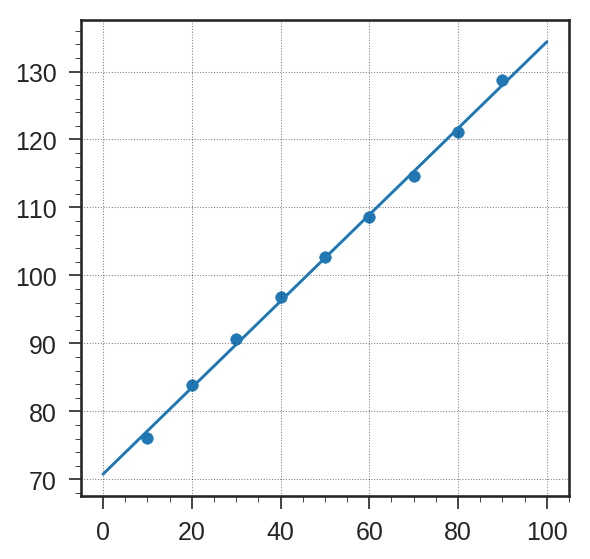

8 [130.8149103507352, 162.45189564179094, 194.0888809328467]


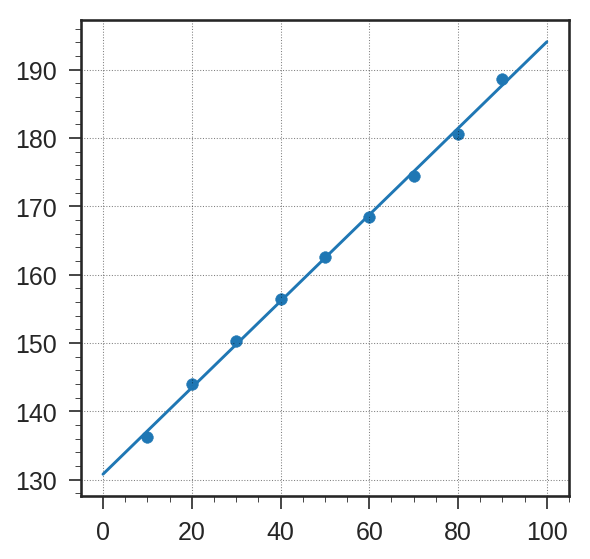

9 [191.18056819565575, 222.95048756142882, 254.72040692720185]


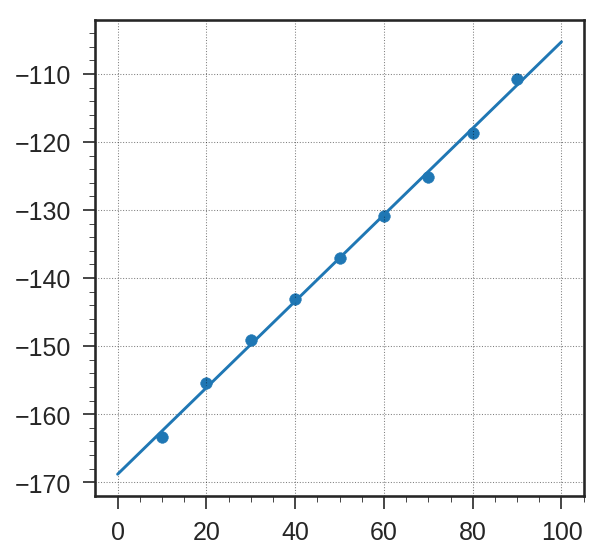

10 [250.28862988088417, 282.2828268181181, 314.277023755352]


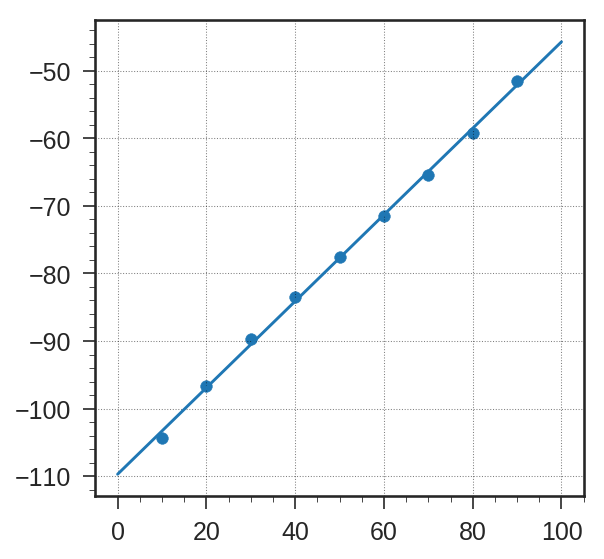

11 [310.4187973683796, 338.8256782651508, 7.232559161922012]


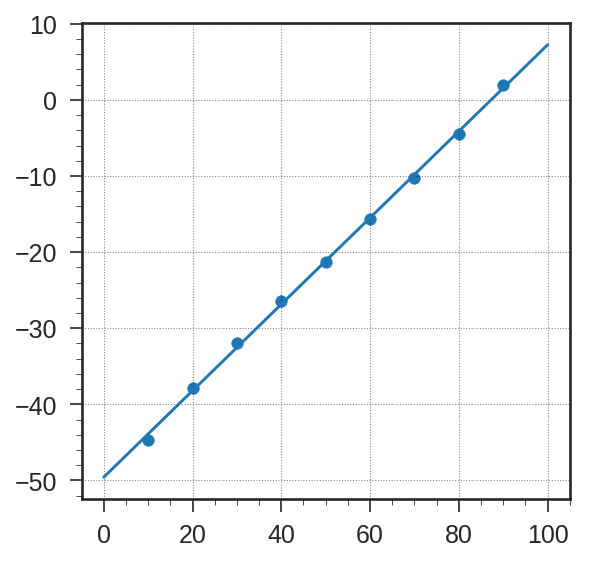

In [7]:
# Results

if True:
  from sklearn.linear_model import LinearRegression
  
  for endsec in xrange(12):
    plt.figure()
    
    phis = out_phis[endsec]
    p = np.array([10,20,30,40,50,60,70,80,90])
    p100 = np.array([0,10,20,30,40,50,60,70,80,90,100])
    pp = np.percentile(phis, p, overwrite_input=True)
    #print endsec, len(phis), pp
    
    lr = LinearRegression()
    lr.fit(p[:,np.newaxis], pp)
    a, b = lr.intercept_, lr.coef_[0]
    fun = lambda x: x if x >= 0. else x + 360.
    print endsec, map(fun, (a, a + b*50, a + b*100))
    
    plt.scatter(p, pp)
    plt.plot(p100, lr.predict(p100[:,np.newaxis]))
    plt.show()

In [8]:
# Results

if True:
  print eta_bins
  for zone in xrange(7):
    print
    for hit_type in xrange(1,5):
      for hit_station in xrange(1,5):
        for hit_ring in xrange(2):
          index = (zone, hit_type, hit_station, hit_ring)
          if index in out_thetas:
            thetas = out_thetas[index]
            if len(thetas) <= 100:  continue
            p = np.array([1,1.5,2,3,4,5,7.5,50,92.5,95,96,97,98,98.5,99])
            pp = np.percentile(thetas, p, overwrite_input=True)
            print index, len(thetas), pp

(2.4, 2.16, 1.98, 1.8, 1.7, 1.56, 1.2, 0.8)

(0, 1, 1, 0) 42139 [ 5.  5.  5.  5.  5.  5.  5. 11. 16. 16. 16. 16. 16. 16. 17.]
(0, 1, 2, 0) 41595 [ 5.  5.  5.  5.  6.  6.  6. 10. 15. 15. 15. 16. 16. 16. 16.]
(0, 1, 3, 0) 39383 [ 5.  5.  5.  6.  6.  6.  6. 10. 15. 15. 15. 15. 16. 16. 16.]
(0, 1, 4, 0) 36510 [ 6.  6.  6.  7.  7.  7.  7. 11. 15. 15. 16. 16. 16. 16. 16.]
(0, 2, 3, 0) 1054 [ 4.  5.  5.  5.  5.  5.  6. 10. 15. 16. 16. 16. 16. 16. 17.]
(0, 2, 4, 0) 1015 [ 5.    5.    5.    5.    5.    6.    6.   10.   15.   16.   16.   16.
 16.   16.79 17.  ]
(0, 3, 1, 0) 2311 [17. 17. 17. 17. 17. 17. 17. 17. 18. 18. 18. 18. 18. 18. 18.]
(0, 3, 2, 0) 38339 [ 7.  7.  7.  7.  7.  7.  7.  8. 13. 13. 13. 18. 18. 18. 19.]
(0, 4, 1, 0) 47231 [ 4.  4.  4.  4.  4.  4.  5. 10. 17. 17. 17. 17. 17. 17. 17.]

(1, 1, 1, 0) 29433 [16. 16. 16. 16. 16. 17. 17. 20. 25. 25. 25. 25. 26. 26. 26.]
(1, 1, 2, 0) 26838 [15. 15. 16. 16. 16. 16. 16. 20. 24. 25. 25. 25. 25. 25. 25.]
(1, 1, 3, 0) 28050 [15. 16. 16. 16. 1